In [2]:
pip install uproot awkward 


  Using cached uproot-5.6.2-py3-none-any.whl.metadata (33 kB)
  Using cached awkward-2.8.4-py3-none-any.whl.metadata (7.0 kB)
  Using cached cramjam-2.10.0-cp313-cp313-win_amd64.whl.metadata (5.1 kB)
  Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached awkward_cpp-46-cp313-cp313-win_amd64.whl.metadata (2.1 kB)
Using cached uproot-5.6.2-py3-none-any.whl (375 kB)
Using cached awkward-2.8.4-py3-none-any.whl (886 kB)
Using cached awkward_cpp-46-cp313-cp313-win_amd64.whl (536 kB)
Using cached cramjam-2.10.0-cp313-cp313-win_amd64.whl (1.7 MB)
Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl (30 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import uproot #allows us to read ROOT files in python
import awkward as ak #helps us deal with jagged arrays , which is what we get from TTree branches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Helper function for drawing 1D histograms
def draw_hist(data, bins, title, xlabel, ylabel='Entries'):
    plt.figure(figsize=(8, 6))
    #Stepfilled is better than bar for root data because the filled area precisely matches the bin edges, doesn't overexaggerate the bin size and is better for Gaussian Fitting
    
    plt.hist(data, bins=bins, histtype='stepfilled', alpha=0.7) #alpha sets the transparency, 1 = solid, 0 = invisible. 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Helper function for drawing 2D hitmap
def draw_hitmap(x, y, xbins, ybins, title):
    plt.figure(figsize=(8, 6))
    #use a rainbow color map because it is more vivid and higher contrast, so easier to see the dense and non-dense regions
    plt.hist2d(x, y, bins=[xbins, ybins], cmap= cm.gist_rainbow) #becuse a hitmap is basically a 2D histogram
    plt.title(title)
    plt.xlabel("Charge Center X")
    plt.ylabel("Charge Center Y")
    plt.colorbar(label='Counts')
    plt.grid(True)
    plt.show()

# Main function
def plot_functions(filename):
    # Open ROOT file by path
    file = uproot.open(filename)

    # Load trees
    if 'raw' not in file or 'data' not in file:
        raise ValueError("ROOT file does not contain expected TTree names 'raw' and 'data'.") #incase given file isnt proper

    tree_raw = file['raw']
    tree_data = file['data']

    # Load branches and branch entries into awkward arrays, so easier to work with 
    apv_id = tree_raw['apv_id'].arrays(library='ak')['apv_id'] #tells you which APV board signal came from
    apv_ch = tree_raw['apv_ch'].arrays(library='ak')['apv_ch'] #tells which channel within that board e.g 0-127 in this case
    mm_strip = tree_raw['mm_strip'].arrays(library='ak')['mm_strip']
    apv_qmax = tree_data['apv_qmax'].arrays(library='ak')['apv_qmax'] #maximum charge amplitude
    apv_tbqmax = tree_data['apv_tbqmax'].arrays(library='ak')['apv_tbqmax'] #time bucket where maximum charge occurred

    # Prepare histograms data arrays. Each list will store 1D data to later plot histograms
    #readout strip numbers useful for checking spatial distribution
    strips_x = [] 
    strips_y = []
    #All APV channels per axis
    ch_x = []
    ch_y = []
    #Calculated average charge centers for each hit
    hit_x = []
    hit_y = []

    # Loop over events, each entry in the TTree
    for i in range(len(apv_id)):
        ids = apv_id[i]
        chs = apv_ch[i]
        strips = mm_strip[i]
        #Accumulate weighted channel positions to compute the average (center-of-charge)
        charge_center_x = 0
        cnt_x = 0
        charge_center_y = 0
        cnt_y = 0

    for i in range(len(apv_id)):
        ids = apv_id[i]
        chs = apv_ch[i]
        strips = mm_strip[i]
        qmaxs = apv_qmax[i]  # <-- include this per event

        charge_center_x = 0
        sum_charge_x = 0
        charge_center_y = 0
        sum_charge_y = 0
        #Loops over channels in current event
        for j in range(len(ids)):
            aid = ids[j] #APV ID tells you which readout group
            ch = chs[j] #Channel Number: 0-127
            strip = strips[j]
            q = qmaxs[j]  # <-- charge on this channel 
            #APV 0 means no offset, APV 1 means offset by 128 because its in the second half
            if aid == 0 or aid == 1:
                strips_x.append(strip)
                if aid == 0:
                    ch_x.append(ch)
                    charge_center_x += ch * q #makes sure to take the weighted average where each channel is weighted by its charge to determine the hit position
                else:  # aid == 1
                    ch_x.append(ch + 128)
                    charge_center_x += (ch + 128) * q
                sum_charge_x += q
            else:
                strips_y.append(strip)
                if aid == 2:
                    ch_y.append(ch)
                    charge_center_y += ch * q
                else:  # aid == 3
                    ch_y.append(ch + 128)
                    charge_center_y += (ch + 128) * q
                sum_charge_y += q
        #only if both X and Y side have valid hits, we compute the 2D Hit point
        if sum_charge_x > 0 and sum_charge_y > 0:
            #takes the weighted average
            cx = charge_center_x / sum_charge_x
            cy = charge_center_y / sum_charge_y
            hit_x.append(cx)
            hit_y.append(cy)



    # Plot histograms
    draw_hist(strips_x, bins=256, title='Strips X', xlabel='Strip')
    draw_hist(strips_y, bins=256, title='Strips Y', xlabel='Strip')
    draw_hist(ch_x, bins=256, title='Channel X', xlabel='Channel')
    draw_hist(ch_y, bins=256, title='Channel Y', xlabel='Channel')
    draw_hist(hit_x, bins=256, title='Hit X', xlabel='Charge Center X')
    draw_hist(hit_y, bins=256, title='Hit Y', xlabel='Charge Center Y')
    draw_hitmap(hit_x, hit_y, xbins=256, ybins=256, title='2D Hit Map')



In [4]:
pwd

'c:\\Users\\syedm\\OneDrive\\Desktop\\Code'

C:\Users\syedm\AppData\Local\Temp\ipykernel_19024\2375290660.py:105: RuntimeWarning: overflow encountered in scalar add
  sum_charge_y += q


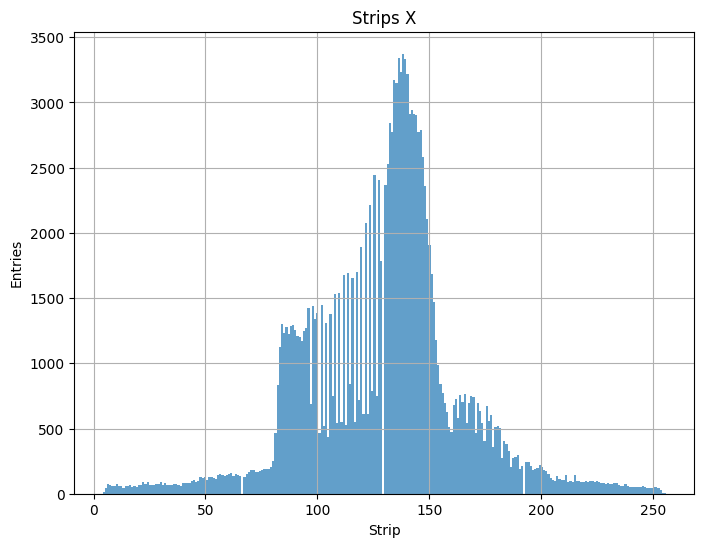

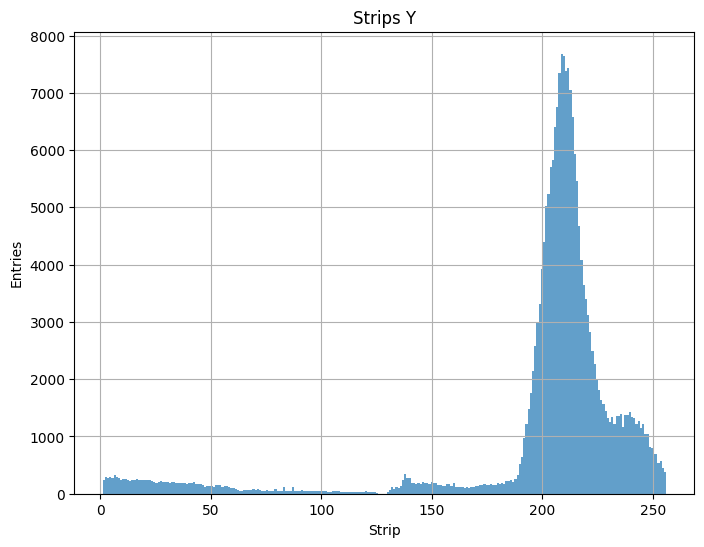

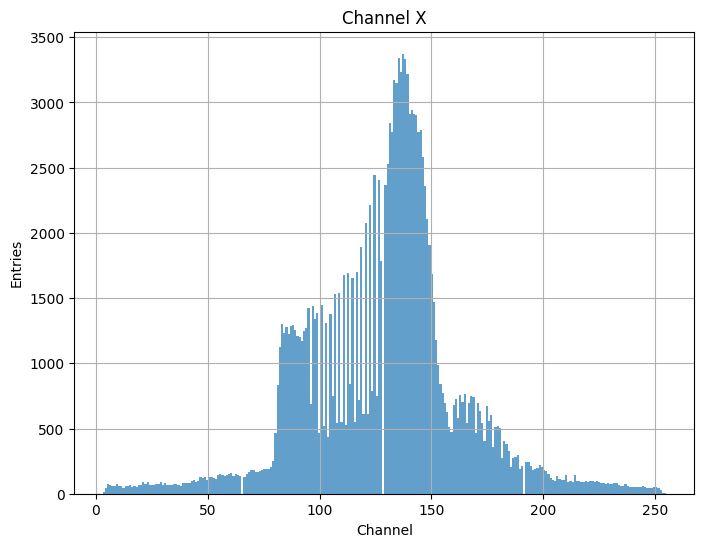

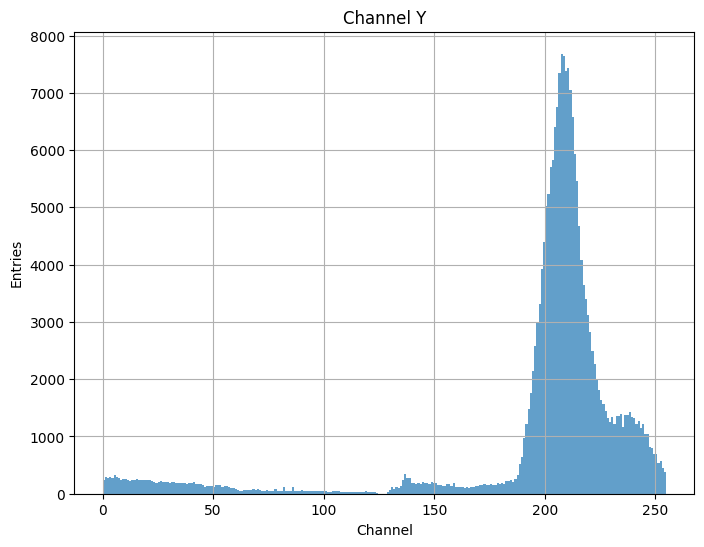

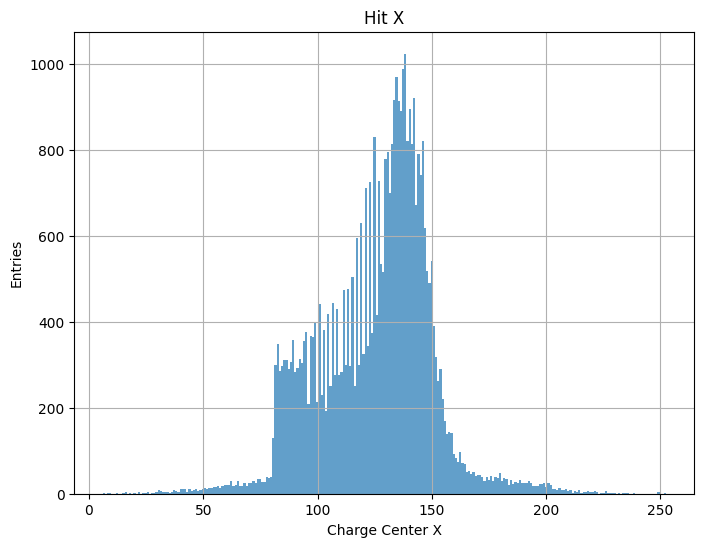

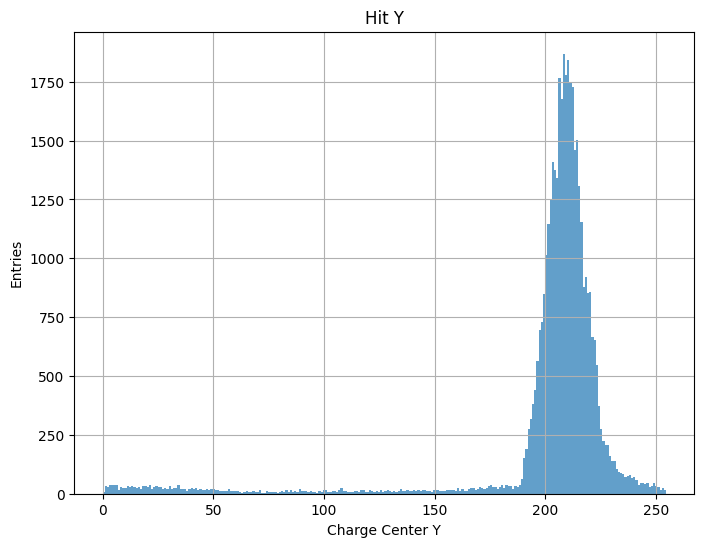

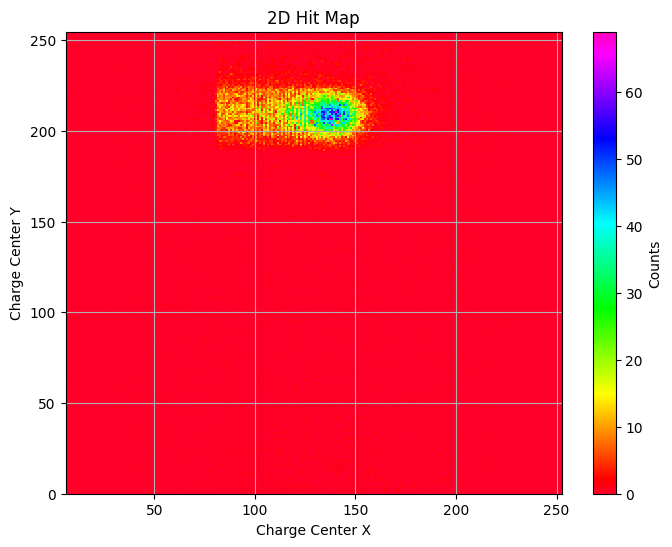

In [22]:
plot_functions(r"C:\Users\syedm\Downloads\run55.root")


## APV SWAPPED


In [3]:
import uproot  # allows us to read ROOT files in python
import awkward as ak  # helps us deal with jagged arrays, which is what we get from TTree branches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Helper function for drawing 1D histograms
def draw_hist(data, bins, title, xlabel, ylabel='Entries'):
    plt.figure(figsize=(8, 6))
    # Stepfilled is better than bar for ROOT-like data because it respects bin edges and is visually accurate for fits
    plt.hist(data, bins=bins, histtype='stepfilled', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


# Helper function for drawing 2D hitmap
def draw_hitmap(x, y, xbins, ybins, title):
    plt.figure(figsize=(8, 6))
    # Use rainbow colormap for better visibility of dense regions
    plt.hist2d(x, y, bins=[xbins, ybins], cmap=cm.gist_rainbow)
    plt.title(title)
    plt.xlabel("Charge Center X")
    plt.ylabel("Charge Center Y")
    plt.colorbar(label='Counts')
    plt.grid(True)
    plt.show()


# Main function
def plot_functions(filename):
    file = uproot.open(filename)

    # Check for expected trees
    if 'raw' not in file or 'data' not in file:
        raise ValueError("ROOT file does not contain expected TTree names 'raw' and 'data'.")

    tree_raw = file['raw']
    tree_data = file['data']

    # Read branches into awkward arrays
    apv_id = tree_raw['apv_id'].arrays(library='ak')['apv_id']
    apv_ch = tree_raw['apv_ch'].arrays(library='ak')['apv_ch']
    mm_strip = tree_raw['mm_strip'].arrays(library='ak')['mm_strip']
    apv_qmax = tree_data['apv_qmax'].arrays(library='ak')['apv_qmax']
    apv_tbqmax = tree_data['apv_tbqmax'].arrays(library='ak')['apv_tbqmax']

    # Histogram data containers
    strips_x = []
    strips_y = []
    ch_x = []
    ch_y = []
    hit_x = []
    hit_y = []

    # Loop over events
    for i in range(len(apv_id)):
        ids = apv_id[i]
        chs = apv_ch[i]
        strips = mm_strip[i]
        qmaxs = apv_qmax[i]

        charge_center_x = 0
        sum_charge_x = 0
        charge_center_y = 0
        sum_charge_y = 0

        # Loop over hits in the event
        for j in range(len(ids)):
            aid = ids[j]
            ch = chs[j]
            strip = strips[j]
            q = qmaxs[j]

            # X-plane logic (unchanged)
            if aid == 0 or aid == 1:
                strips_x.append(strip)
                if aid == 0:
                    ch_x.append(ch)
                    charge_center_x += ch * q
                else:  # aid == 1
                    ch_x.append(ch + 128)
                    charge_center_x += (ch + 128) * q
                sum_charge_x += q

            # ✅ Y-plane logic (APV 2 and 3 are swapped!)
            elif aid == 2 or aid == 3:
                strips_y.append(strip)
                if aid == 3:
                    ch_y.append(ch)
                    charge_center_y += ch * q
                else:  # aid == 2
                    ch_y.append(ch + 128)
                    charge_center_y += (ch + 128) * q
                sum_charge_y += q

        if sum_charge_x > 0 and sum_charge_y > 0:
            cx = charge_center_x / sum_charge_x
            cy = charge_center_y / sum_charge_y
            hit_x.append(cx)
            hit_y.append(cy)

    # Final plotting
    draw_hist(strips_y, bins=384, title='Strips Y', xlabel='Strip')
    draw_hist(ch_y, bins=384, title='Channel Y', xlabel='Channel')
    draw_hist(hit_y, bins=384, title='Hit Y', xlabel='Charge Center Y')
    draw_hitmap(hit_x, hit_y, xbins=384, ybins=256, title='2D Hit Map')


C:\Users\syedm\AppData\Local\Temp\ipykernel_11536\3779233609.py:98: RuntimeWarning: overflow encountered in scalar add
  sum_charge_y += q
C:\Users\syedm\AppData\Local\Temp\ipykernel_11536\3779233609.py:87: RuntimeWarning: overflow encountered in scalar add
  sum_charge_x += q


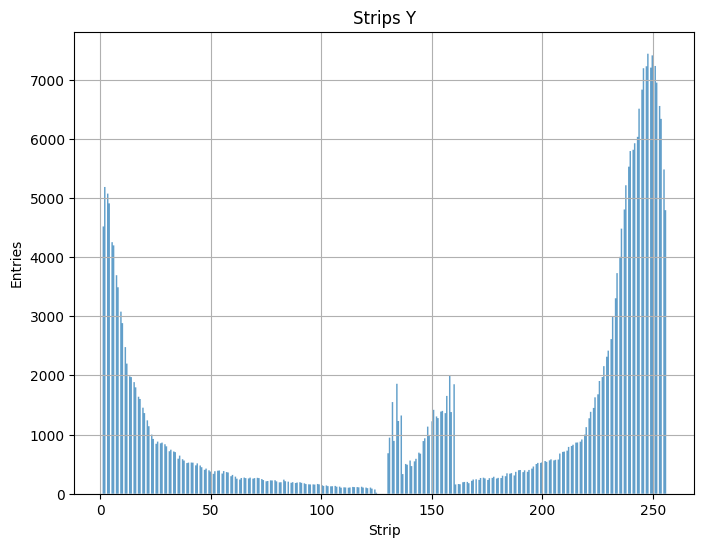

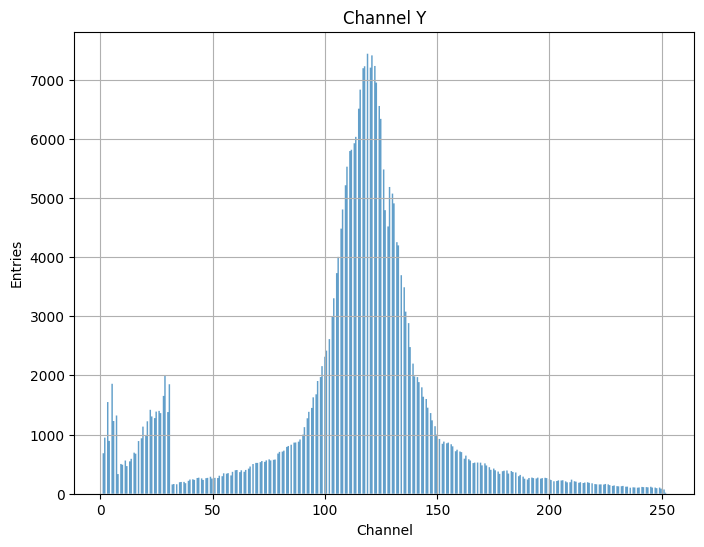

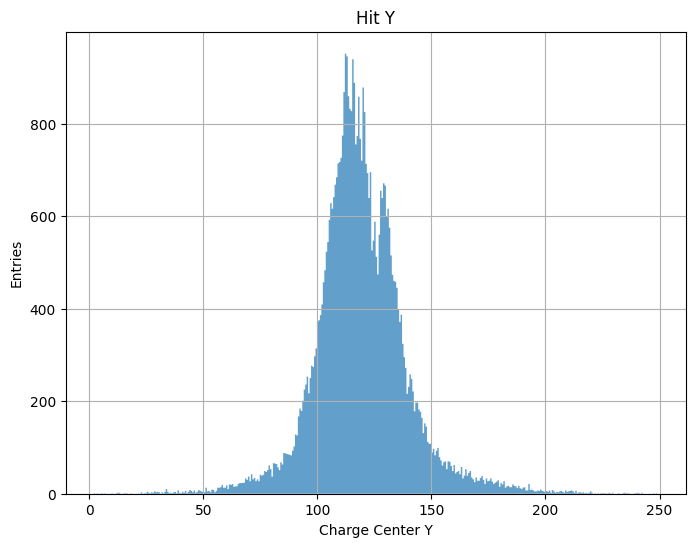

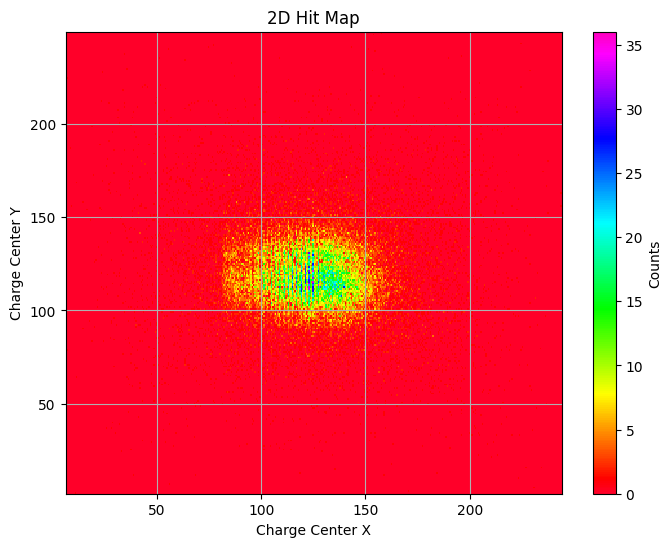

In [4]:
plot_functions(r"C:\Users\syedm\Downloads\run71.root")
